In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import datetime as dt

import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

from src import paths

from ray import tune
from ray.air import session
from ray.train import Checkpoint

In [2]:
SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
ORG_NAME = 'Decentraland'
ORG_PLATFORM = None # Won't be used
LAST_SPLITS = 10 # Used for asserts
USE_ORG_NAMES = ... # Not used
CUTOFF_DATE_STR = '2023-07-29'

OPTIM_METRIC = 'map@10'
OPTIM_MODE = 'max'

SAMPLES_PER_SPLIT: int = 100 # See 07_microsoft_tuning.ipynb

In [3]:
# Parameters
ORG_NAME = "Decentraland"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2023-07-29"


In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

# To evaluate the hybrid recommender system
BEST_HPARAMS_FILE = paths.hybrid_best_hparams(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)
REALISTIC_HPARAMS_FILE = paths.hybrid_realisitc_hparams(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)

pio.templates.default = 'seaborn'

In [5]:
ray_results_path = Path("~/ray_results").expanduser()
assert ray_results_path.is_dir()

In [6]:
last_experiments = sorted(ray_results_path.glob(f'LightGCN_optim={OPTIM_METRIC},dao={ORG_NAME},freq={SPLITS_FREQ},normalize={SPLITS_NORMALIZE},cutoff_date={CUTOFF_DATE.isoformat()},fold=*[0-9]_*'))
print(f"Found {len(last_experiments)} experiments")

class TrainLightGCN:
    def __init__(self):
        raise NotImplementedError

tuners = [ tune.Tuner.restore(str(l), TrainLightGCN) for l in last_experiments ]
result_grids = [ tuner.get_results() for tuner in tuners ]
assert len(result_grids) == LAST_SPLITS

for i, rg in enumerate(result_grids):
    print(f"Fold: {i}, {rg.num_terminated} finished, {rg.num_errors} errors")
    assert rg.num_terminated == SAMPLES_PER_SPLIT
    assert rg.num_errors == 0, "There should be no errors"

Found 10 experiments


Fold: 0, 100 finished, 0 errors
Fold: 1, 100 finished, 0 errors
Fold: 2, 100 finished, 0 errors
Fold: 3, 100 finished, 0 errors
Fold: 4, 100 finished, 0 errors
Fold: 5, 100 finished, 0 errors
Fold: 6, 100 finished, 0 errors
Fold: 7, 100 finished, 0 errors
Fold: 8, 100 finished, 0 errors
Fold: 9, 100 finished, 0 errors


In [7]:
# Checking data from just one experiment

# tune.ExperimentAnalysis(last_experiments[0], default_metric='ndcg@10', default_mode='max').trial_dataframes
pd.concat(result_grids[0]._experiment_analysis.trial_dataframes.values())

iteration      loss   mf_loss  emb_loss  model_recall  model_ndcg  \
0           5  0.388975  0.319169  0.069807      0.009412    0.011792   
1          10  0.499045  0.390885  0.108160      0.013309    0.013874   
2          15  0.536288  0.406636  0.129651      0.029145    0.032304   
3          20  0.564556  0.421909  0.142648      0.003237    0.003384   
4          25  0.551593  0.396787  0.154806      0.015228    0.011528   
..        ...       ...       ...       ...           ...         ...   
35        180  0.574977  0.195740  0.379236      0.028657    0.026224   
36        185  0.593064  0.212731  0.380332      0.023082    0.020166   
37        190  0.602346  0.218210  0.384136      0.003717    0.006739   
38        195  0.572275  0.191158  0.381117      0.005336    0.009649   
39        200  0.608165  0.224052  0.384113      0.022002    0.023766   

    model_precision  model_map  precision@5    ndcg@5  ...  hostname  \
0          0.011511   0.004904     0.266187  0.451469  ...   lamarck   
1          0.007194   0.008633     0.263309  0.465880  ...   lamarck   
2          0.024460   0.017920     0.253237  0.438809  ...   lamarck   
3          0.004317   0.001139     0.247482  0.431646  ...   lamarck   
4          0.012950   0.004924     0.238849  0.401834  ...   lamarck   
..              ...        ...          ...       ...  ...       ...   
35         0.015827   0.016147     0.241727  0.441660  ...   lamarck   
36         0.014388   0.010959     0.244604  0.433980  ...   lamarck   
37         0.005755   0.002638     0.234532  0.408892  ...   lamarck   
38         0.008633   0.003567     0.250360  0.442015  ...   lamarck   
39         0.021583   0.011530     0.254676  0.451135  ...   lamarck   

          node_ip  time_since_restore  iterations_since_restore  config/fold  \
0   147.96.81.131            4.668072                         1            0   
1   147.96.81.131            8.741472                         2            0   
2   147.96.81.131           19.177042                         3            0   
3   147.96.81.131           37.168283                         4            0   
4   147.96.81.131           66.005129                         5            0   
..            ...                 ...                       ...          ...   
35  147.96.81.131          260.132368                        36            0   
36  147.96.81.131          265.645929                        37            0   
37  147.96.81.131          271.254178                        38            0   
38  147.96.81.131          276.696245                        39            0   
39  147.96.81.131          282.273121                        40            0   

    config/batch_size  config/embedding_dim  config/conv_layers  \
0                   8                    29                   5   
1                   8                    29                   5   
2                   8                    29                   5   
3                   8                    29                   5   
4                   8                    29                   5   
..                ...                   ...                 ...   
35                  9                   181                   5   
36                  9                   181                   5   
37                  9                   181                   5   
38                  9                   181                   5   
39                  9                   181                   5   

    config/learning_rate  config/l2  
0                 0.2347   0.000029  
1                 0.2347   0.000029  
2                 0.2347   0.000029  
3                 0.2347   0.000029  
4                 0.2347   0.000029  
..                   ...        ...  
35                0.1499   0.000029  
36                0.1499   0.000029  
37                0.1499   0.000029  
38                0.1499   0.000029  
39                0.1499   0.000029  

[1275 rows x 38 columns]

In [8]:
# Read dataframe and drop some unneeded columns
# rdf = pd.concat([rg.get_dataframe(TARGET, 'max') for rg in result_grids ])
rdf = pd.concat([ pd.concat(rg._experiment_analysis.trial_dataframes.values()) for rg in result_grids ])

drop_cols = [
    'timestamp', 'node_ip', 'pid', 'hostname', 'time_since_restore', # 'checkpoint_dir_name', 'trial_id', # 'logdir'
    'model_recall', 'model_ndcg', 'model_precision', 'model_map', 
    'time_train', 'time_test', 'time_total_s', 'time_this_iter_s',
    'training_iteration', 'iterations_since_restore',
    # 'recall@5', 'map@5', 'recall@10', 'map@10',
]
rdf = rdf.drop(columns=drop_cols)
rdf = rdf.drop(columns=['date']).rename(columns={'config/__trial_index__': 'config/fold', 'iteration':'config/iteration'})
# rdf = rdf[rdf['done']]
print(rdf.columns)

for c in ['config/batch_size']: #, 'config/embedding_dim']:
    rdf[c] = 2**rdf[c]

# rdf[(rdf['config/fold'] >= 1) & (rdf['iteration'] > 10)].sort_values('precision@5').tail()
rdf.sort_values(OPTIM_METRIC).tail()

Index(['config/iteration', 'loss', 'mf_loss', 'emb_loss', 'precision@5',
       'ndcg@5', 'recall@5', 'map@5', 'precision@10', 'ndcg@10', 'recall@10',
       'map@10', 'time_total_train', 'time_total_test', 'done', 'trial_id',
       'config/fold', 'config/batch_size', 'config/embedding_dim',
       'config/conv_layers', 'config/learning_rate', 'config/l2'],
      dtype='object')


config/iteration      loss   mf_loss  emb_loss  precision@5    ndcg@5  \
4                25  0.043679  0.043398  0.000281     0.306542  0.567555   
3                20  0.014810  0.013543  0.001267     0.321495  0.586879   
5                30  0.918408  0.915768  0.002639     0.287850  0.567120   
4                25  0.053500  0.048636  0.004864     0.340187  0.611965   
2                15  0.903263  0.901345  0.001918     0.310280  0.618238   

   recall@5     map@5  precision@10   ndcg@10  ...  time_total_train  \
4  0.671851  0.488954      0.223364  0.691881  ...        180.624061   
3  0.721006  0.500697      0.223364  0.695770  ...        216.724267   
5  0.610303  0.491400      0.223364  0.714104  ...         78.443872   
4  0.742256  0.530336      0.223364  0.709683  ...        118.355091   
2  0.698020  0.553059      0.223364  0.731740  ...         11.736402   

   time_total_test   done  trial_id  config/fold config/batch_size  \
4         4.944447  False  56af58e9            7               512   
3         4.621286  False  c2d30563            7               256   
5         1.016398  False  dfb5440d            7               256   
4         3.651055  False  0e84f93a            7               512   
2         0.765456  False  dfb5440d            7               256   

   config/embedding_dim  config/conv_layers  config/learning_rate  \
4                   290                   4                0.0433   
3                   175                   2                0.0017   
5                     1                   1                0.5557   
4                    47                   4                0.0763   
2                     1                   1                0.5557   

      config/l2  
4  1.014523e-07  
3  3.043272e-05  
5  3.352188e-05  
4  4.372358e-06  
2  3.352188e-05  

[5 rows x 22 columns]

## Check every experiment has ran

In [9]:
_config_cols = [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]

_s = rdf.groupby(_config_cols).size().groupby('config/fold').size()
print(_s)

# Cuidado, no es aleatorio sin reemplazamiento, por lo que
# alguna config, por casualidad, puede estar repetida y es necesario
# usar trial_id
_config_cols.append('trial_id')

_s = rdf.groupby(_config_cols).size().groupby('config/fold').size()
print(_s)
assert all(_s == SAMPLES_PER_SPLIT), "Insufficient number of samples" 

config/fold
0    100
1    100
2     99
3    100
4    100
5    100
6    100
7    100
8    100
9    100
dtype: int64
config/fold
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
dtype: int64


## Total execution time

In [10]:
import datetime as dt

_config_cols = ['trial_id'] + [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]

last_iteration_time = rdf.groupby(_config_cols)['time_total_train'].max()
print(last_iteration_time)
print("Mean exec time: ", dt.timedelta(seconds=last_iteration_time.mean()))
print("Total exec time:", dt.timedelta(seconds=last_iteration_time.sum()))

trial_id  config/fold  config/batch_size  config/embedding_dim  config/conv_layers  config/learning_rate  config/l2   
009e8dde  7            256                817                   3                   0.0002                1.797410e-07    318.930889
00af43fc  0            256                1                     2                   0.5652                1.440015e-05    302.846785
00ba874a  6            128                306                   4                   0.0065                8.923120e-07    380.318138
00cfaf10  8            256                75                    5                   0.0003                1.397536e-06    315.596252
00df7866  0            512                2                     3                   0.0564                3.646905e-07    303.956969
                                                                                                                             ...    
fe889043  4            64                 24                    4                  

## Get baseline

In [11]:
from src import baseline

# bdf = pd.read_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-len(last_experiments):]
# bdf['t'] = pd.to_datetime(bdf['t'])
bdf = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)[-LAST_SPLITS:]
bdf.mean()

precision@5     0.221173
ndcg@5          0.323421
map@5           0.244141
recall@5        0.363084
precision@10    0.195674
ndcg@10         0.422792
map@10          0.318574
recall@10       0.637747
precision@15    0.169712
ndcg@15         0.488284
map@15          0.354573
recall@15       0.843801
dtype: float64

(0.0, 1.0)

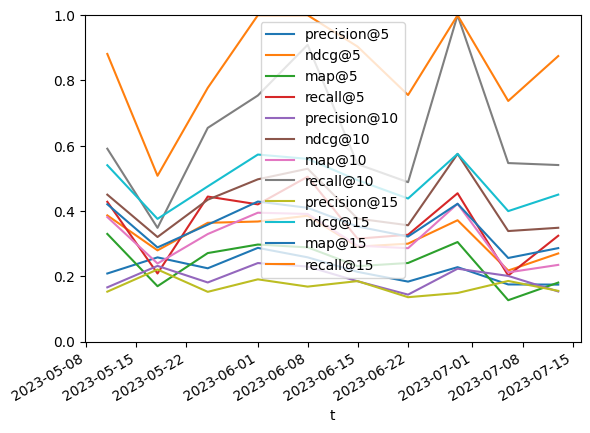

In [12]:
ax = bdf.plot()
ax.set_ylim(0, 1)

# Explore hparams

In [13]:
# Primero, obtenemos la mejor iteración, como si hubiesemos hecho early stopping
hdf = pd.concat(rg.get_dataframe(OPTIM_METRIC, OPTIM_MODE) for rg in result_grids)
hdf

iteration      loss   mf_loss  emb_loss  model_recall  model_ndcg  \
0          45  0.609919  0.428588  0.181331      0.032974    0.026980   
1         100  0.183667  0.173776  0.009892      0.058273    0.041676   
2          20  0.006500  0.006282  0.000218      0.042206    0.044762   
3           5  0.113494  0.113015  0.000479      0.003597    0.001900   
4          15  0.139939  0.087609  0.052330      0.003597    0.001706   
..        ...       ...       ...       ...           ...         ...   
95         25  0.193556  0.191074  0.002482      0.000000    0.000000   
96          5  0.042898  0.021909  0.020989      0.043362    0.044312   
97          5  0.153857  0.115970  0.037887      0.050372    0.043059   
98         10  0.066720  0.066259  0.000460      0.043150    0.036238   
99         15  0.185933  0.180231  0.005702      0.011150    0.008926   

    model_precision  model_map  precision@5    ndcg@5  ...        node_ip  \
0          0.015827   0.019086     0.273381  0.479593  ...  147.96.81.131   
1          0.020144   0.030635     0.258993  0.500120  ...  147.96.81.131   
2          0.033094   0.027638     0.258993  0.472442  ...  147.96.81.131   
3          0.001439   0.000899     0.217266  0.402380  ...  147.96.81.131   
4          0.001439   0.000719     0.227338  0.414523  ...  147.96.81.131   
..              ...        ...          ...       ...  ...            ...   
95         0.000000   0.000000     0.176056  0.258712  ...  147.96.81.131   
96         0.038028   0.021857     0.187324  0.290545  ...  147.96.81.131   
97         0.036620   0.021462     0.200000  0.340670  ...  147.96.81.131   
98         0.030986   0.019261     0.205634  0.349819  ...  147.96.81.131   
99         0.008451   0.003607     0.181690  0.283228  ...  147.96.81.131   

    time_since_restore  iterations_since_restore  config/fold  \
0           223.484393                         9            0   
1           320.817325                        20            0   
2           260.834177                         4            0   
3            41.923079                         1            0   
4           204.829032                         3            0   
..                 ...                       ...          ...   
95          352.063289                         5            9   
96          347.246336                         1            9   
97          376.207523                         1            9   
98          343.452794                         2            9   
99          307.003690                         3            9   

    config/batch_size  config/embedding_dim  config/conv_layers  \
0                   8                    29                   5   
1                   9                     5                   3   
2                   7                   306                   4   
3                   7                   217                   3   
4                   7                     7                   4   
..                ...                   ...                 ...   
95                  9                   380                   5   
96                  7                   731                   5   
97                  7                   950                   5   
98                  7                   480                   2   
99                  7                   151                   3   

    config/learning_rate     config/l2    logdir  
0                 0.2347  2.860601e-05  50e711d6  
1                 0.2200  5.242816e-05  23fe1418  
2                 0.0065  8.923120e-07  255ffd2f  
3                 0.0005  2.791926e-05  844df6e9  
4                 0.0038  3.979960e-03  58971c13  
..                   ...           ...       ...  
95                0.0001  1.600682e-04  08540956  
96                0.0054  2.996307e-04  2b3ae0d5  
97                0.0004  2.357792e-03  3852f46f  
98                0.0002  2.265887e-05  39126830  
99                0.0001  4.834033e-04  f6e980e2  

[10

In [14]:
def download_plotly(fig, filename):
    format = filename.split('.')[-1]

    display(solara.FileDownload(
        data=lambda: fig.to_image(format=format),
        filename=filename,
    ))

In [15]:
import solara
IMAGE_FORMAT = 'pdf'

hdf['config/fold'] = hdf['config/fold'].astype(str)

fig = px.scatter(hdf, x='map@10', y='ndcg@10', color='config/fold')
fig.layout.update(showlegend=False)

download_plotly(fig, 'scatter_ndcg_map.pdf')
fig

Cannot show ipywidgets in text

In [16]:
fig = px.scatter(hdf, x=OPTIM_METRIC, y='precision@10', color='config/fold')
fig.layout.update(showlegend=False)

download_plotly(fig, 'scatter_map_precision.pdf')
fig

Cannot show ipywidgets in text

## Every config vs. metric

In [17]:
def plotly_scatter_config(config, log=True):
    config_cols = [c for c in hdf.columns if c.startswith('config/') ]
    return px.scatter(hdf, x=config, y=OPTIM_METRIC, color='config/fold', marginal_x='rug', marginal_y='rug', log_x=log, hover_data=config_cols)

plotly_scatter_config('config/embedding_dim')

In [18]:
plotly_scatter_config('config/learning_rate')

In [19]:
plotly_scatter_config('config/l2')

In [20]:
plotly_scatter_config('config/batch_size', log=False)

# Best hparams

## What are the best hyperparams per fold?

In [21]:
# We fix the total time in less than 250 so it has time to do the same number of iterations with the next fold
# best = rdf[rdf['time_total_train'] + rdf['time_total_test'] < 250].sort_values(OPTIM_METRIC).drop_duplicates('config/fold', keep='last').set_index('config/fold').sort_index()
best = rdf.sort_values(OPTIM_METRIC).drop_duplicates('config/fold', keep='last').set_index('config/fold').sort_index()
best

config/iteration      loss   mf_loss  emb_loss  precision@5  \
config/fold                                                                
0                          20  2.629414  1.533245  1.096168     0.274820   
1                          30  0.431897  0.409332  0.022565     0.324260   
2                          45  0.181792  0.172447  0.009346     0.280328   
3                           5  0.255664  0.254833  0.000831     0.394059   
4                          75  0.313558  0.310867  0.002691     0.350847   
5                          85  0.184556  0.174617  0.009939     0.289394   
6                         125  0.846347  0.841061  0.005286     0.287838   
7                          15  0.903263  0.901345  0.001918     0.310280   
8                          35  0.010340  0.009826  0.000513     0.263454   
9                          10  0.065127  0.023561  0.041566     0.229577   

               ndcg@5  recall@5     map@5  precision@10   ndcg@10  ...  \
config/fold                                                        ...   
0            0.533089  0.588890  0.456373      0.201439  0.606282  ...   
1            0.436734  0.345719  0.291486      0.272189  0.486249  ...   
2            0.541738  0.573562  0.434213      0.199180  0.591702  ...   
3            0.567747  0.690849  0.456295      0.274257  0.663165  ...   
4            0.591459  0.647680  0.489507      0.255932  0.668391  ...   
5            0.454617  0.468068  0.359070      0.233333  0.560654  ...   
6            0.584152  0.649280  0.499543      0.204054  0.651632  ...   
7            0.618238  0.698020  0.553059      0.223364  0.731740  ...   
8            0.396441  0.431955  0.272603      0.232932  0.490734  ...   
9            0.402814  0.497570  0.298885      0.185211  0.490569  ...   

               map@10  time_total_train  time_total_test   done  trial_id  \
config/fold                                                                 
0            0.516346         85.813447         3.327729  False  636019ac   
1            0.371106         69.812954         2.478821  False  5efaadf5   
2            0.487608         46.136016         1.285662  False  0fc2919d   
3            0.545657        139.920037         4.923971  False  06a6f5ba   
4            0.569160        111.556493         2.909259  False  dbf66eea   
5            0.446157        289.214480         2.632449  False  dbbcb2e6   
6            0.558899        155.934766         3.226803  False  f46fe65f   
7            0.625411         11.736402         0.765456  False  dfb5440d   
8            0.356020        268.415208         3.434468  False  bdd7257c   
9            0.362519         87.856729         3.084392  False  569b1e88   

            config/batch_size  config/embedding_dim  config/conv_layers  \
config/fold                                                               
0                         512                   128                   4   
1                         512                     1                   4   
2                         512                     5                   3   
3                         128                   551                   2   
4                         512                     1                   2   
5                         512                     5                   3   
6                         256                     1                   1   
7                         256                     1                   1   
8                         256                   173                   2   
9                         256                    73                   5   

             config/learning_rate     config/l2  
config/fold                                      
0                          0.3644  2.332245e-05  
1                          0.8071  8.455565e-04  
2                          0.2200  5.242816e-05  
3                          0.0369  2.889943e-07  
4                          0.0610  8.521670e-05  
5                          0.2200  

precision@5     map@10
count    10.000000  10.000000
mean      0.300486   0.483888
std       0.046787   0.096052
min       0.229577   0.356020
25%       0.276197   0.389869
50%       0.288616   0.501977
75%       0.320765   0.555588
max       0.394059   0.625411

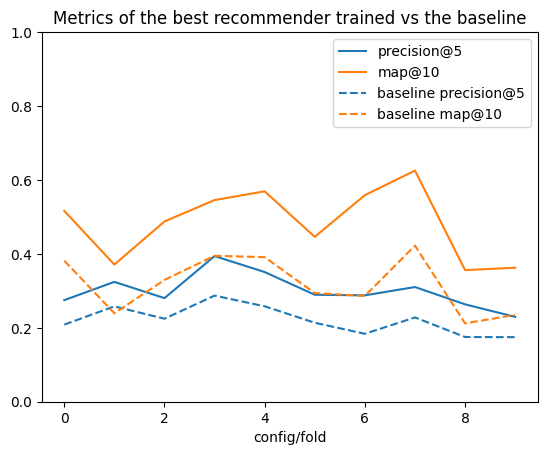

In [22]:
cols2plot = ['precision@5', 'map@10']

ax = best[cols2plot].plot()
ax.set_ylim(0, 1)

bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style='--', color=[l.get_color() for l in ax.lines])

plt.title("Metrics of the best recommender trained vs the baseline")
best[cols2plot].describe()

In [23]:
best[['precision@5', 'ndcg@5', 'precision@10', 'ndcg@10', 'map@5', 'map@10']].mean()

precision@5     0.300486
ndcg@5          0.512703
precision@10    0.228189
ndcg@10         0.594112
map@5           0.411103
map@10          0.483888
dtype: float64

In [24]:
best.reset_index().to_csv(BEST_HPARAMS_FILE)

## Let's be realistic (repeating hparams per folds)

This might not work, its best to execute 

In [25]:
config_cols = [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]
config_cols2 = config_cols + ['config/iteration']
all_configs = rdf.copy()
all_configs['config/fold'] += 1

# Leonardo Torres de Quevedo, perdoname por lo que voy a hacer
all_configs[config_cols] = all_configs[config_cols].astype(str)
all_configs = all_configs.set_index(config_cols)
all_configs_index = all_configs.index

# all_configs_index = pd.MultiIndex.from_frame(all_configs[config_cols].astype(str))[:-1]

# No podemos utilizar los indices "tal cual" pues la coma flotante
# no encaja entre un fold y otro. Así que lo convierto a string
# y luego de nuevo a coma flotante.
# La otra solución sería usar np.isclose, pero habría que programar
# varias lineas y hacer nuestra propia función de búsqueda por cada
# columna o algo así
# O también, en lugar de str, multiplicar por 10^7 (el min. es 10**-7),
# pasar a entero, y luego dividir
aux = rdf.copy()
aux[config_cols] = aux[config_cols].astype(str)
aux = aux.set_index(config_cols)
print("Index intersection:", aux.index.intersection(all_configs_index))
all_realistic = aux.loc[aux.index.intersection(all_configs_index)]
# all_realistic.index = all_realistic.index.set_levels(
#     [ pd.to_numeric(l) for l in realistic.index.levels ]
# )
all_realistic

Index intersection: MultiIndex([('1', '256', '648', '4',                 '0.0176', ...),
            ('1', '512',   '5', '3',                   '0.22', ...),
            ('1', '256',  '29', '5',    '0.23470000000000002', ...),
            ('1', '128', '217', '3',                 '0.0005', ...),
            ('1', '128', '306', '4',   '0.006500000000000001', ...),
            ('1', '128',   '7', '4',                 '0.0038', ...),
            ('1', '128',   '4', '3',                 '0.0002', ...),
            ('1', '256', '412', '4',                 '0.0014', ...),
            ('1',  '64', '206', '1',                 '0.0085', ...),
            ('1', '512', '114', '4',                 '0.0001', ...),
            ...
            ('9', '512', '114', '4',                 '0.0001', ...),
            ('9', '128',  '42', '4',  '0.0012000000000000001', ...),
            ('9', '128',   '6', '4',                 '0.4766', ...),
            ('9', '256',  '87', '4',                 '0.0004', ...)

config/iteration  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                                  
1           256               648                  4                  0.0176               0.00018593067002478325                 5   
                                                                                           0.00018593067002478325                10   
                                                                                           0.00018593067002478325                15   
                                                                                           0.00018593067002478325                20   
                                                                                           0.00018593067002478325                25   
...                                                                                                                             ...   
9           512               47                   4                  0.0763               4.372358023821742e-06                 50   
                                                                                           4.372358023821742e-06                 55   
            128               338                  2                  0.0005               1.0881114993034241e-07                 5   
                                                                                           1.0881114993034241e-07                10   
                                                                                           1.0881114993034241e-07                15   

                                                                                                                       loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           256               648                  4                  0.0176               0.00018593067002478325  0.045377   
                                                                                           0.00018593067002478325  0.051678   
                                                                                           0.00018593067002478325  0.050368   
                                                                                           0.00018593067002478325  0.051075   
                                                                                           0.00018593067002478325  0.048875   
...                                                                                                                     ...   
9           512               47                   4                  0.0763               4.372358023821742e-06   0.071604   
                                                                                           4.372358023821742e-06   0.073612   
            128               338                  2                  0.0005               1.0881114993034241e-07  0.068524   
                                                                                           1.0881114993034241e-07  0.036703   
                                                                                           1.0881114993034241e-07  0.025400   

                                                                                                                    mf_loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           256               648                  4                  0.0176               0.00018593067002478325  0.016535   
                                                                                           0.00018593067002478325  0.016796   
                                                                                           0.00018593067002478325  0.014214   
                                                                        

In [26]:
def bestByFold(df):
    idx = df[OPTIM_METRIC].idxmax()
    return df.loc[idx]

best_configs = (
    all_configs.loc[all_configs.index.intersection(all_realistic.index)]
    .reset_index()
    .groupby("config/fold")
    .apply(bestByFold)
    .set_index(config_cols)
    # .rename(columns="best_{}".format)
)
best_configs

config/iteration  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                                  
1           512               47                   4                  0.0763               4.372358023821742e-06                 30   
2           512               5                    3                  0.22                 5.242816051765795e-05                 75   
3           512               5                    3                  0.22                 5.242816051765795e-05                 45   
4           128               6                    4                  0.4766               2.6657210134240024e-07                 5   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696                75   
6           512               5                    3                  0.22                 5.242816051765795e-05                 85   
7           256               1                    1                  0.5557               3.352187888919367e-05                 95   
8           512               47                   4                  0.0763               4.372358023821742e-06                 25   
9           256               10                   2                  0.0019               3.949771228391859e-06                 60   

                                                                                                                       loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           512               47                   4                  0.0763               4.372358023821742e-06   0.062258   
2           512               5                    3                  0.22                 5.242816051765795e-05   0.184477   
3           512               5                    3                  0.22                 5.242816051765795e-05   0.181792   
4           128               6                    4                  0.4766               2.6657210134240024e-07  1.763399   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696  0.302457   
6           512               5                    3                  0.22                 5.242816051765795e-05   0.184556   
7           256               1                    1                  0.5557               3.352187888919367e-05   0.875657   
8           512               47                   4                  0.0763               4.372358023821742e-06   0.053500   
9           256               10                   2                  0.0019               3.949771228391859e-06   0.031153   

                                                                                                                    mf_loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           512               47                   4                  0.0763               4.372358023821742e-06   0.056978   
2           512               5                    3                  0.22                 5.242816051765795e-05   0.174727   
3           512               5                    3                  0.22                 5.242816051765795e-05   0.172447   
4           128               6                    4                  0.4766               2.6657210134240024e-07  1.762952   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696  0.298812   
6           512               5                    3                  0.22                 5.242816051765795e-05   0.174617   
7           256               1                    1                  0.5557               3.352187888919367e-05   0.870654   
8           512               47                   4                  0.0763            

In [27]:
best_realistic = all_realistic.join(best_configs.rename(columns="best_{}".format), how='right')

# Display the configs, to see that nothing is missing
display(best_realistic.groupby(best_realistic.index).size())

# First, do the "early stopping" (keep only the ones that are the same iterations or less)
best_realistic = best_realistic[best_realistic['config/iteration'] <= best_realistic['best_config/iteration']]
# Now, lets keep just the one with the best iteration
best_realistic = (
    best_realistic.sort_values('config/iteration')
    .groupby('config/fold')
    .tail(1)
    .sort_index()
    .reset_index()
    .set_index('config/fold')
)
best_realistic

(1, 512, 47, 4, 0.0763, 4.372358023821742e-06)                  23
(2, 512, 5, 3, 0.22, 5.242816051765795e-05)                     40
(3, 512, 5, 3, 0.22, 5.242816051765795e-05)                     16
(4, 128, 6, 4, 0.4766, 2.6657210134240024e-07)                   4
(5, 512, 1, 2, 0.030600000000000002, 0.00012097804821179696)    22
(6, 512, 5, 3, 0.22, 5.242816051765795e-05)                     18
(7, 256, 1, 1, 0.5557, 3.352187888919367e-05)                   12
(8, 512, 47, 4, 0.0763, 4.372358023821742e-06)                  14
(9, 256, 10, 2, 0.0019, 3.949771228391859e-06)                  11
dtype: int64

config/batch_size config/embedding_dim config/conv_layers  \
config/fold                                                             
1                         512                   47                  4   
2                         512                    5                  3   
3                         512                    5                  3   
4                         128                    6                  4   
5                         512                    1                  2   
6                         512                    5                  3   
7                         256                    1                  1   
8                         512                   47                  4   
9                         256                   10                  2   

             config/learning_rate               config/l2  config/iteration  \
config/fold                                                                   
1                          0.0763   4.372358023821742e-06                30   
2                            0.22   5.242816051765795e-05                75   
3                            0.22   5.242816051765795e-05                45   
4                          0.4766  2.6657210134240024e-07                 5   
5            0.030600000000000002  0.00012097804821179696                75   
6                            0.22   5.242816051765795e-05                85   
7                          0.5557   3.352187888919367e-05                60   
8                          0.0763   4.372358023821742e-06                25   
9                          0.0019   3.949771228391859e-06                55   

                 loss   mf_loss  emb_loss  precision@5  ...  best_recall@5  \
config/fold                                             ...                  
1            0.052222  0.046939  0.005283     0.269822  ...       0.560865   
2            0.183424  0.173490  0.009934     0.240984  ...       0.354766   
3            0.184341  0.174948  0.009393     0.308911  ...       0.573562   
4            1.711943  1.711499  0.000443     0.333898  ...       0.549775   
5            0.284188  0.280401  0.003787     0.278788  ...       0.633485   
6            0.189341  0.179121  0.010219     0.224324  ...       0.468068   
7            0.884573  0.880589  0.003984     0.314019  ...       0.657917   
8            0.054535  0.049598  0.004937     0.224096  ...       0.742256   
9            0.033913  0.033796  0.000116     0.185915  ...       0.416192   

             best_map@5  best_precision@10  best_ndcg@10  best_recall@10  \
config/fold                                                                
1              0.431752           0.189928      0.568216        0.742615   
2              0.260500           0.278698      0.470472        0.558662   
3              0.434213           0.199180      0.591702        0.746772   
4              0.402731           0.257426      0.608712        0.869832   
5              0.455050           0.256780      0.643262        0.867232   
6              0.359070           0.233333      0.560654        0.769438   
7              0.482731           0.194595      0.626455        0.807466   
8              0.530336           0.223364      0.709683        1.000000   
9              0.270267           0.224096      0.471634        0.644387   

             best_map@10  best_time_total_train  best_time_total_test  \
config/fold                                                             
1               0.484383              96.769575              2.872922   
2               0.346812             318.603211              3.304935   
3               0.487608              46.136016              1.285662   
4               0.492964              86.220595              3.177808   
5               0.535973             265.674926              3.257021   
6               0.446157             289.214480              2.632449   
7               0.532019             311.095119           

precision@5    map@10
count     9.000000  9.000000
mean      0.264529  0.368210
std       0.049305  0.084541
min       0.185915  0.265038
25%       0.224324  0.276081
50%       0.269822  0.386963
75%       0.308911  0.430213
max       0.333898  0.490331

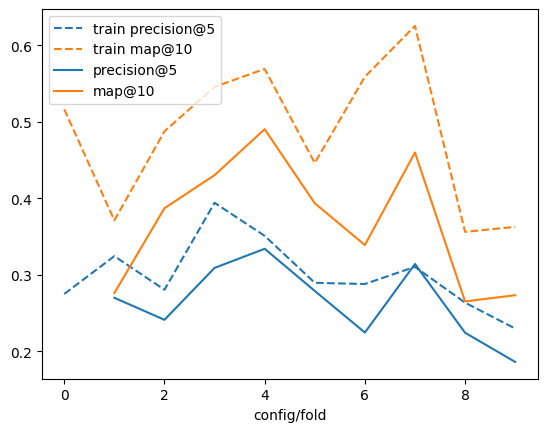

In [28]:
_toplot = best_realistic.copy()
_toplot.index = pd.to_numeric(_toplot.index)

ax = best[cols2plot].rename(columns='train {}'.format).plot(style='--', color=[l.get_color() for l in ax.lines])
# plt.xticks(range(10))
# bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style=':', color=[l.get_color() for l in ax.lines])

_toplot[cols2plot].plot(ax=ax)
# ax.set_ylim(0, 1)

_toplot[cols2plot].describe()

In [29]:
import io

def download_matplotlib(fig: plt.Figure, filename):
    format = filename.split('.')[-1]

    def get_data():
        buf = io.BytesIO()
        fig.savefig(buf, format=format, bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        return buf

    display(solara.FileDownload(
        data=get_data,
        filename=filename,
    ))

Cannot show ipywidgets in text

count      mean       std       min       25%  \
rec       metric                                                       
baseline  map@10        10.0  0.318574  0.076157  0.212009  0.251001   
          precision@5   10.0  0.221173  0.038054  0.174648  0.189996   
oracle    map@10         9.0  0.474460  0.084692  0.344509  0.446157   
          precision@5    9.0  0.305215  0.037089  0.253815  0.280328   
realistic map@10         9.0  0.368210  0.084541  0.265038  0.276081   
          precision@5    9.0  0.264529  0.049305  0.185915  0.224324   

                            50%       75%       max  
rec       metric                                     
baseline  map@10       0.311767  0.388681  0.422290  
          precision@5  0.219113  0.250500  0.287129  
oracle    map@10       0.487608  0.532019  0.599718  
          precision@5  0.293243  0.340187  0.349153  
realistic map@10       0.386963  0.430213  0.490331  
          precision@5  0.269822  0.308911  0.333898

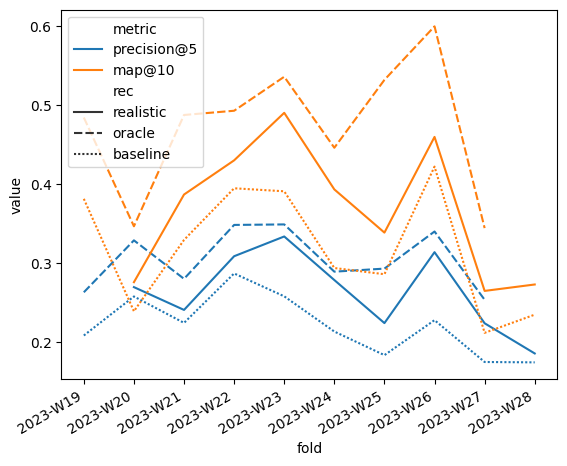

In [30]:
_toplot = best_realistic.copy()
_toplot.index = pd.to_numeric(_toplot.index)
_toplot['best_config/fold'] = _toplot.index - 1
_toplot = _toplot.reset_index()

_cols = ['config/fold'] + cols2plot
_toplot_real = _toplot[_cols].copy()
_toplot_real['rec'] = 'realistic'

_colsbest = map("best_{}".format, _cols)
_toplot_best = _toplot[_colsbest].rename(columns=lambda x: x.split("_", 1)[-1])
_toplot_best['rec'] = 'oracle'

_toplot_base = bdf[cols2plot].copy()
_toplot_base['config/fold'] = range(len(_toplot_base))
_toplot_base['rec'] = 'baseline'

_toplot = (
    pd.concat((
        _toplot_real, 
        _toplot_best,
        _toplot_base,
    ), ignore_index=True)
    .melt(id_vars=['config/fold', 'rec'], value_vars=cols2plot, var_name='metric')
)
ax = sns.lineplot(_toplot, x='config/fold', y='value', hue='metric', style='rec')
ax.set_xlabel('fold')
# ax.set_xticks(np.arange(10), bdf['t'].dt.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xticks(np.arange(10), bdf.index.strftime('%G-W%V'), rotation=30, ha='right')

download_matplotlib(ax.figure, '09_gnn_results.pdf')

_toplot.groupby(['rec', 'metric'])['value'].describe()

## !!OLD GRAPHS!! (might not work)

In [31]:
# config_cols = [ c for c in configs.columns if c.startswith('config/') ]
# px.scatter(configs, x='ndcg@5', y='time_total_train', hover_data=config_cols)

In [32]:
# sns.swarmplot(configs, x='config/conv_layers', y='ndcg@5', hue='time_total_train', palette='flare')

In [33]:
# sns.swarmplot(configs, x='config/batch_size', y='ndcg@5', hue='time_total_train', palette='flare')
# # plt.xscale('log', base=2)

In [34]:
# sns.violinplot(configs, x='config/batch_size', y='time_total_train', inner='point')

In [35]:
# sns.scatterplot(configs, x='config/learning_rate', y='ndcg@5', hue='time_total_train', palette='flare')
# plt.xscale('log')

In [36]:
# sns.scatterplot(configs, x='config/l2', y='ndcg@5', hue='time_total_train', palette='flare')
# plt.xscale('log')

In [37]:
# sns.scatterplot(configs, x='config/embedding_dim', y='ndcg@5', hue='time_total_train', palette='flare')